<h1> <center> Naive Bayes for Spam Classification

The goal of this project is to classify the text into spam/ham using Naive Bayes algorithm. Naive Bayes is supervised learning algoirthm that uses probabilities to perform the classification. The following equation is used for classifying text messages:

![image.png](https://www.geeksforgeeks.org/wp-content/ql-cache/quicklatex.com-f3637f468262bfbb4accb97da8110028_l3.svg)


In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import operator
import string
import matplotlib.pyplot as plt
import math
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, plot_confusion_matrix

<h3> 1. Load Data

In [2]:
data = pd.read_csv('SMSSpamCollection',sep='\t', header=None)
data = data.rename(columns={0:'label',1:'text'})
df = pd.DataFrame(data)

,label,text
0,ham,4825
1,spam,747


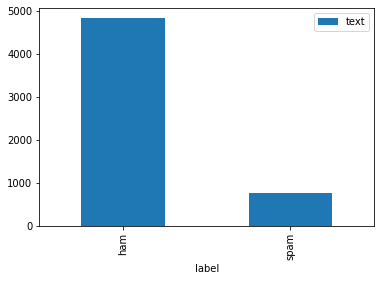

In [3]:
#Check total number of ham and spam messages
df_count = data.groupby(['label']).count().reset_index()
df_count.plot(kind='bar',x='label',y='text')
df_count

This document consist of 4825 ham messages and 747 spam messages.

<h3> 2. Data Pre-processing </h3>


The following function "clean_string" was used to preprocess the text messages in the document. The entire document was converted into lower case, then the punctuations and stopwords were removed. Then, the text messages were tokenized and stemmed (Porter stemmer).

In [4]:
def clean_string(df_raw):
    stop = stopwords.words('english')
    ps = PorterStemmer()

    #stopwords removed and text converted to lower case
    df_raw['text1'] = df_raw['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])).str.lower()

    #remove punctuations
    df_raw['no_punct'] = df_raw['text1'].str.replace('[{}]'.format(string.punctuation), '')
    
    #porter stemmer
    df_raw['tokenized_text']=df_raw['no_punct'].apply(lambda x : filter(None,x.split(" ")))
    df_raw['stemmed_text']=df_raw['tokenized_text'].apply(lambda x : [ps.stem(y) for y in x])
    df_raw['clean_text']=df_raw['stemmed_text'].apply(lambda x : " ".join(x))
    df1 = df_raw[["label", "clean_text"]]
    return(df1)

df = clean_string(df)
df.head(5)

,label,clean_text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah i think goe usf live around though


<h3> 3. Data Training </h3>

<h4> STEPS </h4>

1. Vocabulary: A dataframe of unique words from entire text message was created using "get_vocab()" function.

2. The data was then split into train and test dataset. For each class (Ham/Spam) in the training set, following calculations were performed:

    • spam_texts = training messages for which the classification is spam
    • ham_texts = training messages for which the classification is ham

    • total_prob_spam = Probability estimate of spam class
    • total_prob_ham = Probability estimate of ham class

    • words_spam = A single file for spam class (concatenated all spam Msgs)
    • words_ham = A single file for ham class (concatenated all ham Msgs)

    • ns = total number of word positions in words_spam (For spam)
    • nh = total number of word positions in words_ham (For ham)

    • spam_count = number of times each words occurs in words_spam
    • ham_count = number of times each words occurs in words_ham

    • spam_prob = Probability of kth word in vocabulary, given a message of type spam
    • ham_prob = Probability of kth word in vocabulary, given a message of type ham

In [5]:
def get_vocab(df): 
    #create list on unique words
    main_series = df['clean_text'].str.split(' ',expand = True).stack().value_counts()
    vocab_df1 = main_series.index.to_frame()
    vocab_df = pd.DataFrame({'vocab':vocab_df1.index})
    return(vocab_df)

vocab_df = get_vocab(df)

def for_each_class(vocab_df,train_df):
    
    vocabulary = len(vocab_df)
    
    #probability for two classes
    spam_texts = train_df[train_df['label'] == 'spam']
    ham_texts = train_df[train_df['label'] == 'ham']
   
    total_prob_spam = round((len(spam_texts)/len(train_df)), 2)
    total_prob_ham = round((len(ham_texts)/len(train_df)), 2)
    #return(total_prob_spam, total_prob_ham)
    
    #list of words in spam
    #words in spam
    words_spam = spam_texts['clean_text'].apply(lambda x: (x.split(" "))).sum(axis = 0)
        
    #total number of words in spam
    ns = len(words_spam)
    
    #list of words in ham
    words_ham = ham_texts['clean_text'].apply(lambda x: (x.split(" "))).sum(axis = 0)
        
    #total number of words in ham
    nh = len(words_ham)
       
    spam_count = []
    ham_count = []
    ham_prob = []
    spam_prob = []

    for row in vocab_df['vocab']:
        spam_count.append(words_spam.count(row))
        ham_count.append(words_ham.count(row))
    vocab_df['spam_count'] = spam_count   
    vocab_df['ham_count'] = ham_count   

    for row in vocab_df['spam_count']:
        spam_prob.append(cal_probability(row,ns,vocabulary))

    for row in vocab_df['ham_count']:
        ham_prob.append(cal_probability(row,nh,vocabulary))

    vocab_df['spam_prob'] = spam_prob   
    vocab_df['ham_prob'] = ham_prob      
    
    return(vocab_df, total_prob_spam,total_prob_ham)
       
def cal_probability(nk,n,vocabs):
    result = (nk+1)/(n+vocabs)
    return result

train_df = df.sample(frac=0.7,random_state=100)
vocab_df, total_prob_spam,total_prob_ham= for_each_class(vocab_df,train_df)

In [6]:
vocab_df.head(10)

,vocab,spam_count,ham_count,spam_prob,ham_prob
0,i,28,1023,0.001617,0.025206
1,u,93,660,0.005240,0.016271
2,call,256,190,0.014327,0.004702
3,you,91,276,0.005129,0.006818
4,2,115,214,0.006467,0.005292
5,im,8,301,0.000502,0.007434
6,go,28,299,0.001617,0.007385
7,get,59,257,0.003345,0.006351
8,ur,102,162,0.005742,0.004012
9,it,7,225,0.000446,0.005563


<h3> 4. Class Prediction </h3>

Following functions were used to determine the class for each text messages in test dataset. 

For each row in the dataset, the text messages were split into word. For each words, the corresponding probability value were obtained from the trained dataset (vocab_df). The words not found in the vocabulary were ignored. After determining the probability of each word for every row, the product of probabilities of spam and ham for each sentence were calculated using log (log (a * b) = log(a) + log(b)) since the computation might result in arithmetic underflow.

The class was then predicted as Ham if the probability values for ham class is higher than spam class and vice versa. 

In [7]:
def classify(spam_val,ham_val):
    if spam_val > ham_val:
        return 'spam'
    else:
        return 'ham'
    
def predict(test_df, vocab_df, total_prob_spam,total_prob_ham):   
    test = test_df.reset_index()
    test['spam_value']=""
    test['ham_value']=""
    test['Predicted_class']=""

    row_index = 0
    for row in test['clean_text']:
        p=row.split()
        sum1,sum2, mainsum = 0,0,0
        for i in p:
            if i in vocab_df.vocab.values:
                dfbb = int(vocab_df[vocab_df['vocab']==i].index[0]) #returns index number from vocab_df
                #print(dfbb)
                #print(i)
                prob_val_spam = vocab_df['spam_prob'][dfbb]
                sum1 = sum1 + math.log10(prob_val_spam)

                prob_val_ham = vocab_df['ham_prob'][dfbb]
                sum2 = sum2 + math.log10(prob_val_ham)
            else:
                pass

        mainsum1 = sum1+math.log10(total_prob_spam)
        #print(mainsum1)
        test['spam_value'][row_index] = mainsum1

        mainsum2 = sum2+math.log10(total_prob_ham)
        #print(mainsum2)
        test['ham_value'][row_index] = mainsum2

        test['Predicted_class'][row_index] = classify(mainsum1,mainsum2)

        row_index+=1
        
    return(test)

In [8]:
test_df = df.drop(train_df.index)
vocab_df,total_prob_spam,total_prob_ham= for_each_class(vocab_df,train_df)
test = predict(test_df, vocab_df, total_prob_spam,total_prob_ham) 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
test.head(10)

,index,label,clean_text,spam_value,ham_value,Predicted_class
0,2,spam,free entri 2 wkli comp win fa cup final tkt 21...,-74.8796,-93.0891,spam
1,3,ham,u dun say earli hor u c alreadi say,-33.1424,-25.6572,ham
2,6,ham,even brother like speak me they treat like aid...,-38.4619,-32.6589,ham
3,7,ham,as per request mell mell oru minnaminungint nu...,-67.9025,-63.7573,ham
4,11,spam,six chanc win cash from 100 20000 pound txt cs...,-70.8023,-87.7866,spam
5,13,ham,ive search right word thank breather i promis ...,-66.4925,-59.0313,ham
6,17,ham,eh u rememb 2 spell name ye did he v naughti m...,-51.1316,-44.1937,ham
7,18,ham,fine that way u feel that way gota b,-36.0186,-29.6068,ham
8,20,ham,is serious spell name,-15.6137,-13.888,ham
9,21,ham,i‘m go tri 2 month ha ha joke,-29.2269,-25.2452,ham


<h3>5. Evaluation </h3>


K-Fold cross validation was used to evaluate the model. The dataset was split into five equal partitions where one fold was used as test set and the remaining folds were used as training set. The model evaluation metrics such as accuracy, precision, recall as well as confusion matrix were then used to evaluate its performance.

In [10]:
cv = KFold(n_splits = 5, random_state = 0)
scores = []
precs = []
recalls = []
confusion = np.array([[0, 0], [0, 0]])

for train_index, test_index in cv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    
    vocab_df = get_vocab(df)
    
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
 
    vocab_df,total_prob_spam,total_prob_ham= for_each_class(vocab_df,train_df)
    
    test = predict(test_df, vocab_df, total_prob_spam,total_prob_ham) 

    #print(test.head(10))

    confusion += confusion_matrix(test.label, test.Predicted_class)
    score = f1_score(test.label, test.Predicted_class,pos_label=['ham','spam'],average= 'weighted')
    scores.append(score)
    
    prec = precision_score(test.label, test.Predicted_class,pos_label=['ham','spam'],average= 'weighted')
    precs.append(prec)
    recall = recall_score(test.label, test.Predicted_class,pos_label=['ham','spam'],average= 'weighted')
    recalls.append(recall)
    

    print('Total emails classified:', len(df))
    print('Accuracy of model is:', np.mean(scores))
    print('Precision of model is:', np.mean(precs))
    print('Recall of model is:', np.mean(recalls))
    print('Confusion matrix:')
         
    print(confusion)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


TRAIN: [1115 1116 1117 ... 5569 5570 5571] TEST: [   0    1    2 ... 1112 1113 1114]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to ['ham', 'spam']

Total emails classified: 5572
Accuracy of model is: 0.9733499645615055
Precision of model is: 0.9737846812948175
Recall of model is: 0.9730941704035875
Confusion matrix:
[[928  19]
 [ 11 157]]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [1115 1116 1117 ... 2227 2228 2229]
Total emails classified: 5572
Accuracy of model is: 0.9781930751254619
Precision of model is: 0.9784638428356818
Recall of model is: 0.9780269058295965
Confusion matrix:
[[1891   30]
 [  19  290]]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [2230 2231 2232 ... 3341 3342 3343]
Total emails classified: 5572
Accuracy of model is: 0.9789197727882285
Precision of model is: 0.9791589578671124
Recall of model is: 0.9787683860527651
Confusion matrix:
[[2855   43]
 [  28  418]]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [3344 3345 3346 ... 4455 4456 4457]
Total emails classified: 5572
Accuracy of model is: 0.9781386808887612
Precision of model is: 0.9783269356035412
Recall of model is: 0.9780170435790712
Confus

<h3>6. Conclusion</h3>

Therefore, the following values were obtained from the spam classifier model:
    TP = 4751 (cases for which ham text message were actually predicted as ham)
    FP = 74 (cases for which ham text message were incorrectly predicted spam)
    FN = 49 (cases for which spam text message were incorrectly predicted as ham)
    TN = 698 (cases for which spam text message were actually predicted as spam)
    Accuracy = 97.80%
    Precision = 97.83%
    Recall = 97.79%

Using this model, for each 100 text messages it classified, 97 were correctly classified. Around 3% of the "ham" text messages were incorrectly classified as "Spam". Similarly, the number of "spam" text messages that were incorrectly classified as "Ham" were only around 3%. These values were quite low which indicated that the model was quite precise.

Although this model has good performance for given dataset, it might not work well with new dataset as it ignored words not found in vocabulary. This is one of the limitations that could be further studied.

<h4> Comparison with existing Naive Bayes library </h4>

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

cv = KFold(n_splits = 5, random_state = 0)
scores = []
precs = []
recalls = []
confusion = np.array([[0, 0], [0, 0]])

for train_index, test_index in cv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
 
    vectorizer = CountVectorizer()
    counts = vectorizer.fit_transform(train_df['clean_text'].values)
    test1 = vectorizer.transform(test_df['clean_text'].values)

    classifier = MultinomialNB()
    #Train the model using the training sets
    classifier.fit(counts,train_df['label'].values)

    #Predict the response for test dataset
    ypred = classifier.predict(test1)

    #print(test.head(10))

    confusion += confusion_matrix(test_df.label, ypred)
    score = f1_score(test_df.label, ypred,pos_label=['ham','spam'],average= 'weighted')
    scores.append(score)
    
    prec = precision_score(test_df.label, ypred,pos_label=['ham','spam'],average= 'weighted')
    precs.append(prec)
    recall = recall_score(test_df.label, ypred,pos_label=['ham','spam'],average= 'weighted')
    recalls.append(recall)
    

    print('Total emails classified:', len(df))
    print('Accuracy of model is:', np.mean(scores))
    print('Precision of model is:', np.mean(precs))
    print('Recall of model is:', np.mean(recalls))
    print('Confusion matrix:')
         
    print(confusion)

TRAIN: [1115 1116 1117 ... 5569 5570 5571] TEST: [   0    1    2 ... 1112 1113 1114]
Total emails classified: 5572
Accuracy of model is: 0.9854678188643197
Precision of model is: 0.9856017648005403
Recall of model is: 0.9856502242152466
Confusion matrix:
[[944   3]
 [ 13 155]]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [1115 1116 1117 ... 2227 2228 2229]
Total emails classified: 5572
Accuracy of model is: 0.9845343950454976
Precision of model is: 0.9846560092663301
Recall of model is: 0.9847533632286996
Confusion matrix:
[[1914    7]
 [  27  282]]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [2230 2231 2232 ... 3341 3342 3343]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to ['ham', 'spam']) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to ['ham', 'spam']) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to ['ham

Total emails classified: 5572
Accuracy of model is: 0.9854173392645901
Precision of model is: 0.9856000370231385
Recall of model is: 0.9856464671674274
Confusion matrix:
[[2890    8]
 [  40  406]]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [3344 3345 3346 ... 4455 4456 4457]
Total emails classified: 5572
Accuracy of model is: 0.9851664010003932
Precision of model is: 0.9854164274164297
Recall of model is: 0.9854197695856244
Confusion matrix:
[[3847    9]
 [  56  546]]
TRAIN: [   0    1    2 ... 4455 4456 4457] TEST: [4458 4459 4460 ... 5569 5570 5571]
Total emails classified: 5572
Accuracy of model is: 0.9850582106718846
Precision of model is: 0.9852527438107378
Recall of model is: 0.9852837510365425
Confusion matrix:
[[4810   15]
 [  67  680]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to ['ham', 'spam']) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to ['ham', 'spam']) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Using the existing Naive Bayes library, similar results were obtained with an accuracy of 98%, precision of 98% and recall of 98%.